# Desafio de Risco de Crédito
1. Definição do problema e métrica
    - Tipo de problema: Classificação binária probabilística
    - Objetivo: Prever a probabilidade $P(y=1 \mid X)$ de o empréstimo ser pago.
    - Métrica de sucesso: AUC-ROC (Área sob a curva ROC)


2. Engenharia de atributos
    - Análise exploratória de dados (EDA)
    - Tratamento de valores ausentes
    - Codificação de variáveis categóricas
    - Normalização/Padronização de variáveis numéricas
    - Criação de novas features relevantes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import TargetEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

/Users/gustavoroos/projects/personal/mestrado/ml/trab/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [3]:
TARGET = 'loan_paid_back'
ID_COL = 'id'

X = train_df.drop(columns=[TARGET, ID_COL])
y = train_df[TARGET]

**Possivel problema**: conjunto de dados desbalanceados (mais empréstimos pagos (80%) do que não pagos (20%)). Estratégias como oversampling, undersampling ou geração de dados sintéticos (SMOTE) podem ser consideradas.

In [4]:
missing_data = X.isnull().sum()
print(f'Dados faltantes por coluna:\n{missing_data[missing_data > 0]}')

Dados faltantes por coluna:
Series([], dtype: int64)


In [5]:
print('Valores únicos da coluna gender:')
print(X['gender'].value_counts())

Valores únicos da coluna gender:
gender
Female    306175
Male      284091
Other       3728
Name: count, dtype: int64


In [6]:
print('Valores únicos da coluna grade_subgrade:')
print(X['grade_subgrade'].unique())
print(f'Total de únicos: {X["grade_subgrade"].nunique()}')
grade_mapping = {f'{grade}{subgrade}': i for i, (grade, subgrade) in enumerate(
    [(g, s) for g in 'ABCDEF' for s in range(1, 6)]
)}
print(f'Grade mapping:\n{grade_mapping}')
print(f'Total de keys no mapeamento: {len(grade_mapping)}')

Valores únicos da coluna grade_subgrade:
['C3' 'D3' 'C5' 'F1' 'D1' 'D5' 'C2' 'C1' 'F5' 'D4' 'C4' 'D2' 'E5' 'B1'
 'B2' 'F4' 'A4' 'E1' 'F2' 'B4' 'E4' 'B3' 'E3' 'B5' 'E2' 'F3' 'A5' 'A3'
 'A1' 'A2']
Total de únicos: 30
Grade mapping:
{'A1': 0, 'A2': 1, 'A3': 2, 'A4': 3, 'A5': 4, 'B1': 5, 'B2': 6, 'B3': 7, 'B4': 8, 'B5': 9, 'C1': 10, 'C2': 11, 'C3': 12, 'C4': 13, 'C5': 14, 'D1': 15, 'D2': 16, 'D3': 17, 'D4': 18, 'D5': 19, 'E1': 20, 'E2': 21, 'E3': 22, 'E4': 23, 'E5': 24, 'F1': 25, 'F2': 26, 'F3': 27, 'F4': 28, 'F5': 29}
Total de keys no mapeamento: 30


In [7]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f'Colunas numéricas ({len(num_cols)}): {num_cols}')
print(f'Colunas categóricas ({len(cat_cols)}): {cat_cols}')

Colunas numéricas (5): ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']
Colunas categóricas (6): ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']


In [8]:
target_enc_cols = ['loan_purpose', 'employment_status', 'gender', 'marital_status']
train_df[target_enc_cols]

,loan_purpose,employment_status,gender,marital_status
0,Other,Self-employed,Female,Single
1,Debt consolidation,Employed,Male,Married
2,Debt consolidation,Employed,Male,Single
3,Debt consolidation,Employed,Female,Single
4,Other,Employed,Male,Married
...,...,...,...,...
593989,Business,Employed,Female,Single
593990,Debt consolidation,Employed,Male,Single
593991,Debt consolidation,Employed,Female,Married
593992,Debt consolidation,Employed,Male,Single


In [9]:
def plot_roc_curve(y_true, y_proba, auc_score, title='Curva ROC'):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [10]:
def preprocess_data(X, y):
    X = X.copy()

    cat_cols = X.select_dtypes(include=['object']).columns.tolist()
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

    for col in cat_cols:
        X[col] = X[col].fillna(X[col].mode()[0])

    for col in num_cols:
        X[col] = X[col].fillna(X[col].median())

    ordinal_mappings = {
        'education_level': {
            'High School': 1,
            'Other': 1,
            "Bachelor's": 2,
            "Master's": 3,
            'PhD': 4
        },
        'grade_subgrade': grade_mapping
    }

    for col, mapping in ordinal_mappings.items():
        X[col] = X[col].map(mapping)

    target_enc_cols = ['loan_purpose', 'employment_status']
    te = TargetEncoder(random_state=42)

    X[target_enc_cols] = te.fit_transform(X[target_enc_cols], y)

    remaining_cat_cols = [
        col for col in cat_cols
        if col not in ['education_level', 'grade_subgrade'] + target_enc_cols
    ]

    X = pd.get_dummies(X, columns=remaining_cat_cols, drop_first=True)

    X['income_to_loan_ratio'] = X['annual_income'] / (X['loan_amount'] + 1)
    X['monthly_burden'] = X['loan_amount'] * (X['interest_rate'] / 100) / 12

    return X, y

In [11]:
X_processed, y_processed = preprocess_data(X, y)
X_train, X_val, y_train, y_val = train_test_split(X_processed, y_processed, test_size=0.2, random_state=42, stratify=y_processed)

print(f'Train shape: {X_train.shape}')
print(f'Validation shape: {X_val.shape}')

Train shape: (475195, 16)
Validation shape: (118799, 16)


In [12]:
baseline_dtc = DecisionTreeClassifier(random_state=42)
baseline_dtc.fit(X_train, y_train)

dtc_preds = baseline_dtc.predict_proba(X_val)[:, 1]
dtc_auc = roc_auc_score(y_val, dtc_preds)
print(f'Baseline Decision Tree Classifier AUC-ROC: {dtc_auc:.4f}')

Baseline Decision Tree Classifier AUC-ROC: 0.7745


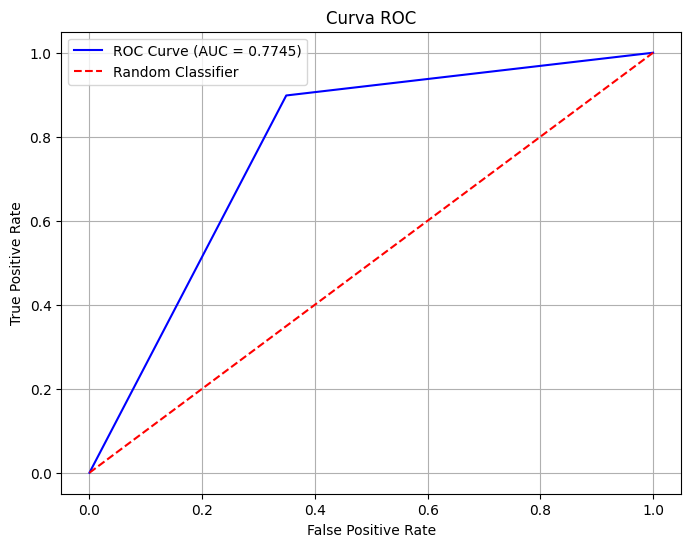

In [13]:
plot_roc_curve(y_val, dtc_preds, dtc_auc)

In [14]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

rf_preds = rf.predict_proba(X_val)[:, 1]
rf_auc = roc_auc_score(y_val, rf_preds)
print(f'Baseline Random Forest AUC-ROC: {rf_auc:.4f}')

Baseline Random Forest AUC-ROC: 0.9081


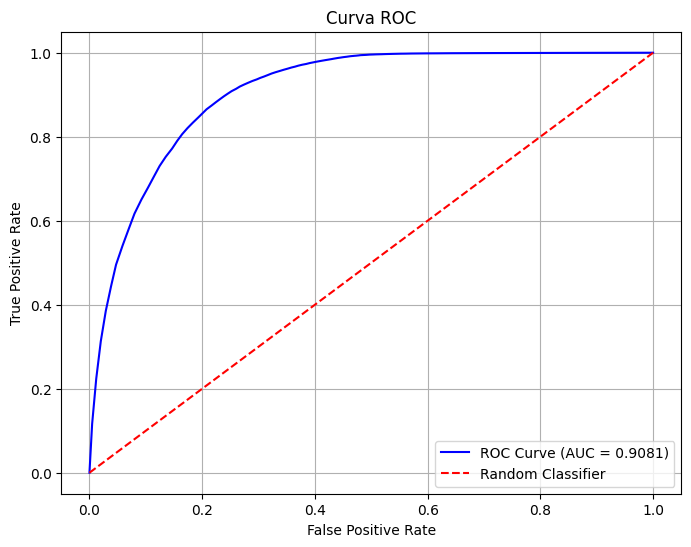

In [15]:
plot_roc_curve(y_val, rf_preds, rf_auc)

In [16]:
xgb = XGBClassifier(n_estimators=100, eval_metric='auc', scale_pos_weight=1, objective='binary:logistic')
xgb.fit(X_train, y_train)

xgb_preds = xgb.predict_proba(X_val)[:, 1]
xgb_auc = roc_auc_score(y_val, xgb_preds)
print(f'XGBoost AUC-ROC: {xgb_auc:.4f}')

XGBoost AUC-ROC: 0.9216


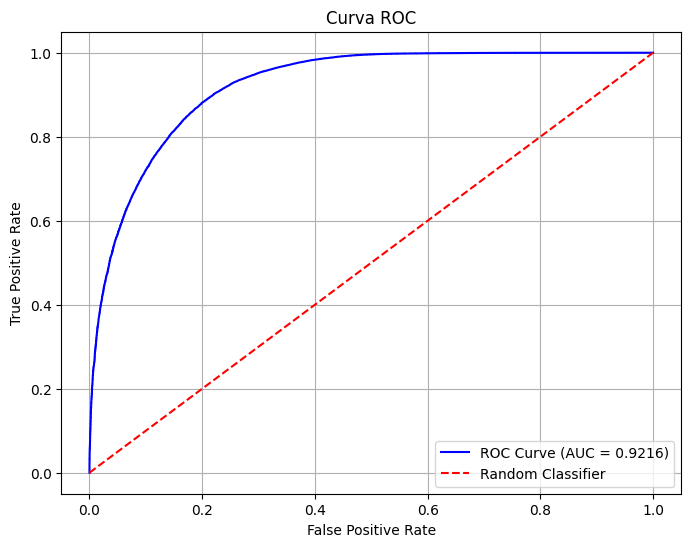

In [17]:
plot_roc_curve(y_val, xgb_preds, xgb_auc)

## Hyperparameter Tuning com RandomizedSearchCV e K-Fold

Utilizando `Pipeline` do scikit-learn para evitar data leakage durante a validação cruzada, especialmente com o `TargetEncoder`.

Estratégias:
- **StratifiedKFold**: Mantém a proporção das classes em cada fold (80/20)
- **RandomizedSearchCV**: Busca aleatória de hiperparâmetros (mais eficiente que GridSearchCV para grids grandes)
- **Pipeline**: Encapsula preprocessing + modelo, garantindo que o encoding seja fitado apenas nos dados de treino de cada fold

In [18]:
target_enc_cols = ['loan_purpose', 'employment_status']
ordinal_cols = ['education_level', 'grade_subgrade']
onehot_cols = ['gender', 'marital_status']

education_categories = ['High School', 'Other', "Bachelor's", "Master's", 'PhD']
grade_categories = [f'{g}{s}' for g in 'ABCDEF' for s in range(1, 6)]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), num_cols),

        ('target_enc', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', TargetEncoder(random_state=42))
        ]), target_enc_cols),

        ('ordinal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder(
                categories=[education_categories, grade_categories],
                handle_unknown='use_encoded_value',
                unknown_value=-1
            ))
        ]), ordinal_cols),

        ('onehot', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
        ]), onehot_cols),
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

print('Preprocessor criado com sucesso!')

Preprocessor criado com sucesso!


In [19]:
X_raw = train_df.drop(columns=[TARGET, ID_COL])
y_raw = train_df[TARGET]

In [20]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])

rf_param_dist = {
    'classifier__n_estimators': [50, 80, 100],
    'classifier__max_depth': [10, 15, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__class_weight': ['balanced', None]
}

rf_random_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_param_dist,
    n_iter=10,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True
)

print('Iniciando RandomizedSearchCV para Random Forest...')
rf_random_search.fit(X_raw, y_raw)

print(f'Melhor AUC-ROC (CV): {rf_random_search.best_score_:.4f}')
print(f'Melhores parâmetros: {rf_random_search.best_params_}')

Iniciando RandomizedSearchCV para Random Forest...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END classifier__class_weight=None, classifier__max_depth=15, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=80; total time= 1.3min
[CV] END classifier__class_weight=None, classifier__max_depth=15, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=80; total time= 1.3min
[CV] END classifier__class_weight=None, classifier__max_depth=15, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=80; total time= 1.3min
[CV] END classifier__class_weight=None, classifier__max_depth=15, classifier__min_samples_leaf=4, classifier__min_samples_split=5, classifier__n_estimators=100; total time= 1.6min
[CV] END classifier__class_weight=None, classifier__max_depth=15, classifier__min_samples_leaf=4, classifier__min_samples_split=5, classifier__n_estimators=100; total time

In [21]:
rf_cv_results = pd.DataFrame(rf_random_search.cv_results_)
rf_cv_results_sorted = rf_cv_results.sort_values('rank_test_score')[
    ['rank_test_score', 'mean_test_score', 'std_test_score', 'mean_train_score', 'params']
].head(10)

print('Top 10 combinações de hiperparâmetros - Random Forest:')
rf_cv_results_sorted

Top 10 combinações de hiperparâmetros - Random Forest:


,rank_test_score,mean_test_score,std_test_score,mean_train_score,params
5,1,0.913885,0.000737,0.939989,"{'classifier__n_estimators': 100, 'classifier_..."
7,2,0.913821,0.000723,0.935851,"{'classifier__n_estimators': 50, 'classifier__..."
2,3,0.913691,0.000727,0.936285,"{'classifier__n_estimators': 100, 'classifier_..."
1,4,0.913314,0.000852,0.940844,"{'classifier__n_estimators': 80, 'classifier__..."
0,5,0.913117,0.000506,0.963185,"{'classifier__n_estimators': 100, 'classifier_..."
6,6,0.912202,0.000778,0.916196,"{'classifier__n_estimators': 100, 'classifier_..."
8,7,0.912103,0.000822,0.916128,"{'classifier__n_estimators': 80, 'classifier__..."
4,8,0.912042,0.000774,0.916216,"{'classifier__n_estimators': 80, 'classifier__..."
3,9,0.911977,0.000765,0.976459,"{'classifier__n_estimators': 80, 'classifier__..."
9,10,0.911596,0.000763,0.970460,"{'classifier__n_estimators': 50, 'classifier__..."


In [22]:
df = train_df.copy()
X_raw = df.drop(columns=[TARGET, ID_COL])
y_raw = df[TARGET].astype(int)

n_neg, n_pos = np.bincount(y_raw)
scale_pos_weight_value = n_neg / n_pos
print(f'scale_pos_weight calculado: {scale_pos_weight_value:.2f}')

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
print(f'Cross-validation: {cv.get_n_splits()} folds estratificados')

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, n_jobs=-1, verbosity=0, objective='binary:logistic', metric='auc'))
])

xgb_param_dist = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
    'classifier__min_child_weight': [1, 3],
    'classifier__subsample': [0.8, 0.9],
    'classifier__colsample_bytree': [0.7, 0.8],
    'classifier__scale_pos_weight': [1, scale_pos_weight_value]
}

def roc_auc_scorer(estimator, X, y):
    if hasattr(estimator, "predict_proba"):
        y_score = estimator.predict_proba(X)[:, 1]
    else:
        y_score = estimator.predict(X)
    return roc_auc_score(y, y_score)

xgb_random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=xgb_param_dist,
    n_iter=10,
    cv=cv,
    scoring=roc_auc_scorer,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True,
    error_score='raise'
)

print('Iniciando RandomizedSearchCV para XGBoost...')
xgb_random_search.fit(X_raw, y_raw)

print(f'Melhor AUC-ROC (CV): {xgb_random_search.best_score_:.4f}')
print(f'Melhores parâmetros: {xgb_random_search.best_params_}')

scale_pos_weight calculado: 0.25
Cross-validation: 3 folds estratificados
Iniciando RandomizedSearchCV para XGBoost...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END classifier__colsample_bytree=0.7, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__min_child_weight=1, classifier__n_estimators=50, classifier__scale_pos_weight=0.25184723094496453, classifier__subsample=0.9; total time=  19.5s
[CV] END classifier__colsample_bytree=0.7, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__min_child_weight=1, classifier__n_estimators=50, classifier__scale_pos_weight=0.25184723094496453, classifier__subsample=0.9; total time=  19.8s
[CV] END classifier__colsample_bytree=0.7, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__min_child_weight=1, classifier__n_estimators=50, classifier__scale_pos_weight=0.25184723094496453, classifier__subsample=0.9; total time=  19.8s
[CV] END classifier__colsample_bytree=0.7, classifie

In [23]:
xgb_cv_results = pd.DataFrame(xgb_random_search.cv_results_)
xgb_cv_results_sorted = xgb_cv_results.sort_values('rank_test_score')[
    ['rank_test_score', 'mean_test_score', 'std_test_score', 'mean_train_score', 'params']
].head(10)

print('Top 10 combinações de hiperparâmetros - XGBoost:')
xgb_cv_results_sorted

Top 10 combinações de hiperparâmetros - XGBoost:


,rank_test_score,mean_test_score,std_test_score,mean_train_score,params
4,1,0.921702,0.000560,0.927391,"{'classifier__subsample': 0.8, 'classifier__sc..."
0,2,0.921633,0.000510,0.931481,"{'classifier__subsample': 0.8, 'classifier__sc..."
6,3,0.921501,0.000719,0.933224,"{'classifier__subsample': 0.8, 'classifier__sc..."
8,4,0.921282,0.000751,0.926601,"{'classifier__subsample': 0.9, 'classifier__sc..."
5,5,0.919935,0.000715,0.924002,"{'classifier__subsample': 0.9, 'classifier__sc..."
7,6,0.918920,0.000672,0.920392,"{'classifier__subsample': 0.8, 'classifier__sc..."
2,7,0.918370,0.000708,0.919950,"{'classifier__subsample': 0.8, 'classifier__sc..."
9,8,0.917329,0.000693,0.918263,"{'classifier__subsample': 0.8, 'classifier__sc..."
3,9,0.916532,0.000850,0.917255,"{'classifier__subsample': 0.8, 'classifier__sc..."
1,10,0.913693,0.000695,0.913938,"{'classifier__subsample': 0.9, 'classifier__sc..."


In [24]:
comparison_df = pd.DataFrame({
    'Modelo': ['Random Forest (Tuned)', 'XGBoost (Tuned)'],
    'Melhor AUC-ROC': [rf_random_search.best_score_, xgb_random_search.best_score_],
})

print('Comparação dos Modelos Otimizados:')
print(comparison_df.to_string(index=False))
print()

best_model_name = comparison_df.loc[comparison_df['Melhor AUC-ROC'].idxmax(), 'Modelo']
final_best_score = comparison_df['Melhor AUC-ROC'].max()
print(f'Melhor modelo: {best_model_name} com AUC-ROC = {final_best_score:.4f}')

print('\nMelhores parâmetros RF:')
print(f'  {rf_random_search.best_params_}')
print('\nMelhores parâmetros XGBoost:')
print(f'  {xgb_random_search.best_params_}')

Comparação dos Modelos Otimizados:
               Modelo  Melhor AUC-ROC
Random Forest (Tuned)        0.913885
      XGBoost (Tuned)        0.921702

Melhor modelo: XGBoost (Tuned) com AUC-ROC = 0.9217

Melhores parâmetros RF:
  {'classifier__n_estimators': 100, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 15, 'classifier__class_weight': 'balanced'}

Melhores parâmetros XGBoost:
  {'classifier__subsample': 0.8, 'classifier__scale_pos_weight': 1, 'classifier__n_estimators': 150, 'classifier__min_child_weight': 1, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.2, 'classifier__colsample_bytree': 0.8}


### Cross-Validation dos Melhores Modelos

In [25]:
df = train_df.copy()
X_full = df.drop(columns=[TARGET, ID_COL])
y_full = df[TARGET].astype(int)

cv_final = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(f'Dados: {X_full.shape[0]} amostras')
print(f'Cross-validation: {cv_final.get_n_splits()} folds estratificados')

Dados: 593994 amostras
Cross-validation: 5 folds estratificados


In [26]:
best_rf = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=5,
    min_samples_leaf=4,
    max_depth=15,
    class_weight=None,
    random_state=42,
    n_jobs=-1
)

best_xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.2,
    max_depth=7,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

print('Melhores modelos definidos!')

Melhores modelos definidos!


In [27]:
print('Cross-Validation - Random Forest')
print('='*50)

rf_fold_scores = []

for fold_idx, (train_idx, val_idx) in enumerate(cv_final.split(X_full, y_full)):
    X_train_fold = X_full.iloc[train_idx]
    X_val_fold = X_full.iloc[val_idx]
    y_train_fold = y_full.iloc[train_idx]
    y_val_fold = y_full.iloc[val_idx]

    X_train_proc, _ = preprocess_data(X_train_fold, y_train_fold)
    X_val_proc, _ = preprocess_data(X_val_fold, y_val_fold)

    best_rf.fit(X_train_proc, y_train_fold)
    rf_preds_fold = best_rf.predict_proba(X_val_proc)[:, 1]
    fold_auc = roc_auc_score(y_val_fold, rf_preds_fold)

    rf_fold_scores.append(fold_auc)
    print(f'  Fold {fold_idx + 1}: AUC-ROC = {fold_auc:.4f}')

rf_mean = np.mean(rf_fold_scores)
rf_std = np.std(rf_fold_scores)
print(f'Média: {rf_mean:.4f} ± {rf_std:.4f}')

Cross-Validation - Random Forest
  Fold 1: AUC-ROC = 0.9148
  Fold 2: AUC-ROC = 0.9143
  Fold 3: AUC-ROC = 0.9133
  Fold 4: AUC-ROC = 0.9141
  Fold 5: AUC-ROC = 0.9138
Média: 0.9141 ± 0.0005


In [28]:
print('Cross-Validation - XGBoost')
print('='*50)

xgb_fold_scores = []

for fold_idx, (train_idx, val_idx) in enumerate(cv_final.split(X_full, y_full)):
    X_train_fold = X_full.iloc[train_idx]
    X_val_fold = X_full.iloc[val_idx]
    y_train_fold = y_full.iloc[train_idx]
    y_val_fold = y_full.iloc[val_idx]

    X_train_proc, _ = preprocess_data(X_train_fold, y_train_fold)
    X_val_proc, _ = preprocess_data(X_val_fold, y_val_fold)

    best_xgb.fit(X_train_proc, y_train_fold)
    xgb_preds_fold = best_xgb.predict_proba(X_val_proc)[:, 1]
    fold_auc = roc_auc_score(y_val_fold, xgb_preds_fold)

    xgb_fold_scores.append(fold_auc)
    print(f'  Fold {fold_idx + 1}: AUC-ROC = {fold_auc:.4f}')

xgb_mean = np.mean(xgb_fold_scores)
xgb_std = np.std(xgb_fold_scores)
print(f'Média: {xgb_mean:.4f} ± {xgb_std:.4f}')

Cross-Validation - XGBoost
  Fold 1: AUC-ROC = 0.9226
  Fold 2: AUC-ROC = 0.9222
  Fold 3: AUC-ROC = 0.9202
  Fold 4: AUC-ROC = 0.9216
  Fold 5: AUC-ROC = 0.9213
Média: 0.9216 ± 0.0008


In [29]:
cv_summary = pd.DataFrame({
    'Modelo': ['Random Forest', 'XGBoost'],
    'Média AUC-ROC': [rf_mean, xgb_mean],
    'Desvio Padrão': [rf_std, xgb_std]
})

print('Resumo da Cross-Validation (5 folds):')
print(cv_summary.to_string(index=False))

winner = 'XGBoost' if xgb_mean > rf_mean else 'Random Forest'
winner_score = max(xgb_mean, rf_mean)
print(f'\nMelhor modelo: {winner} com AUC-ROC = {winner_score:.4f}')

Resumo da Cross-Validation (5 folds):
       Modelo  Média AUC-ROC  Desvio Padrão
Random Forest       0.914052       0.000474
      XGBoost       0.921552       0.000820

Melhor modelo: XGBoost com AUC-ROC = 0.9216


## Explicabilidade com SHAP
Utilizando SHAP (SHapley Additive exPlanations) para entender quais features mais influenciam as predições do modelo XGBoost.

In [30]:
df_train = train_df.copy()
X_train_final = df_train.drop(columns=[TARGET, ID_COL])
y_train_final = df_train[TARGET]

X_train_processed = preprocessor.fit_transform(X_train_final, y_train_final)

best_xgb.fit(X_train_processed, y_train_final)

print('Modelo treinado no dataset completo!')
print(f'Shape treino: {X_train_processed.shape}')

Modelo treinado no dataset completo!
Shape treino: (593994, 14)


In [31]:
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)

X_shap = X_train_df.sample(n=50000, random_state=42)

explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer(X_shap)

print(f'SHAP values calculados para {len(X_shap)} amostras')

SHAP values calculados para 50000 amostras


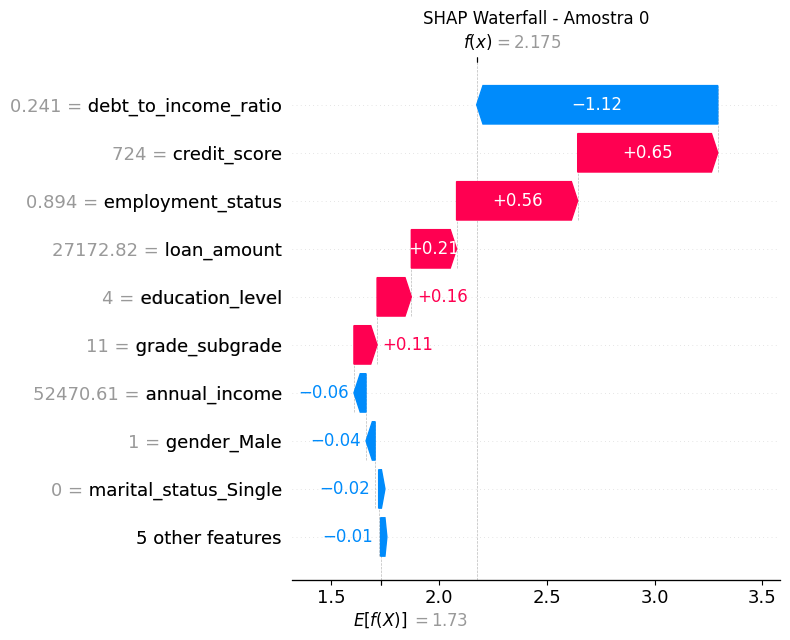

In [32]:
idx = 0
shap.plots.waterfall(shap_values[idx], max_display=10, show=False)
plt.title(f'SHAP Waterfall - Amostra {idx}')
plt.tight_layout()
plt.show()

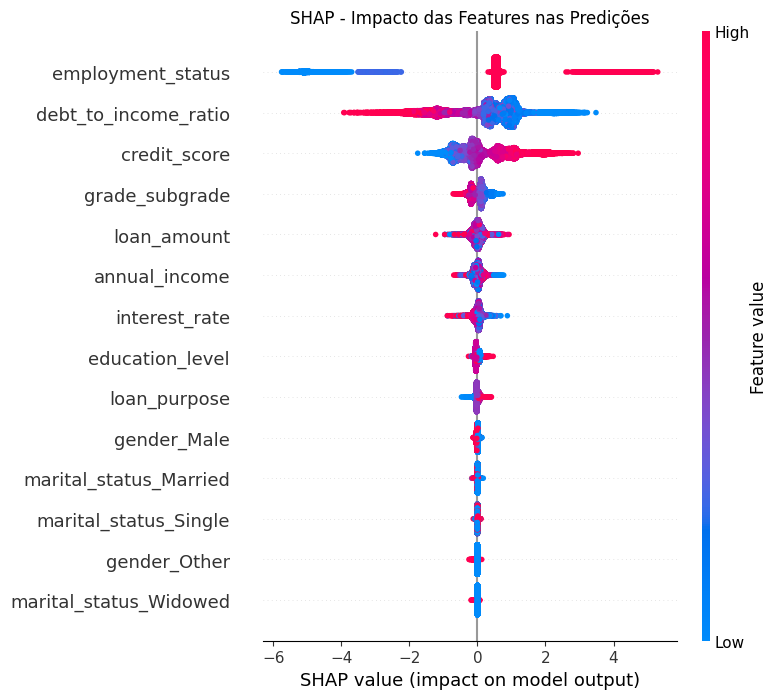

In [33]:
plt.figure(figsize=(10, 8))
shap.plots.beeswarm(shap_values, max_display=15, show=False)
plt.title('SHAP - Impacto das Features nas Predições')
plt.tight_layout()
plt.show()

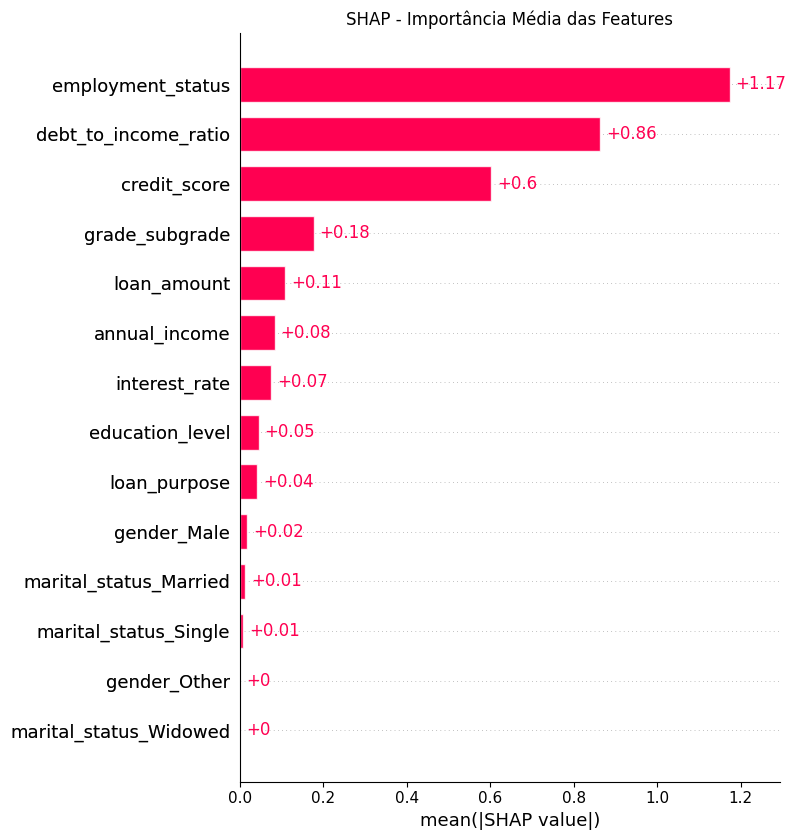

In [34]:
plt.figure(figsize=(10, 8))
shap.plots.bar(shap_values, max_display=15, show=False)
plt.title('SHAP - Importância Média das Features')
plt.tight_layout()
plt.show()

In [35]:
feature_importance_df = pd.DataFrame({
    'Feature': X_shap.columns,
    'Mean |SHAP|': np.abs(shap_values.values).mean(axis=0)
}).sort_values('Mean |SHAP|', ascending=False).reset_index(drop=True)

print('Top 10 Features mais Importantes (SHAP):')
print(feature_importance_df.head(10).to_string(index=False))

feature_importance_df.to_csv('data/shap_feature_importance.csv', index=False)

Top 10 Features mais Importantes (SHAP):
             Feature  Mean |SHAP|
   employment_status     1.174021
debt_to_income_ratio     0.863102
        credit_score     0.602620
      grade_subgrade     0.177087
         loan_amount     0.109183
       annual_income     0.083985
       interest_rate     0.074738
     education_level     0.045562
        loan_purpose     0.041643
         gender_Male     0.017117


## Redução de Features
Com base na análise SHAP, removemos features com baixa importância para simplificar o modelo.

In [36]:
num_cols = X_raw.select_dtypes(include=[np.number]).columns.tolist()
target_enc_cols = ['employment_status']
ordinal_cols = ['education_level', 'grade_subgrade']

education_categories = ['High School', 'Other', "Bachelor's", "Master's", 'PhD']
grade_categories = [f'{g}{s}' for g in 'ABCDEF' for s in range(1, 6)]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), num_cols),

        ('target_enc', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', TargetEncoder(random_state=42))
        ]), target_enc_cols),

        ('ordinal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder(
                categories=[education_categories, grade_categories],
                handle_unknown='use_encoded_value',
                unknown_value=-1
            ))
        ]), ordinal_cols),
    ],
    remainder='drop',
    verbose_feature_names_out=True
)

print('Novo preprocessor criado com sucesso!')

Novo preprocessor criado com sucesso!


In [37]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

print(f'Cross-validation: {cv.get_n_splits()} folds estratificados')

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=8))
])

rf_param_dist = {
    'classifier__n_estimators': [50, 80, 100],
    'classifier__max_depth': [10, 15, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__class_weight': ['balanced', None]
}

rf_random_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_param_dist,
    n_iter=10,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True
)

print('Iniciando RandomizedSearchCV para Random Forest...')
rf_random_search.fit(X_raw, y_raw)

print(f'Melhor AUC-ROC (CV): {rf_random_search.best_score_:.4f}')
print(f'Melhores parâmetros: {rf_random_search.best_params_}')

Cross-validation: 3 folds estratificados
Iniciando RandomizedSearchCV para Random Forest...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END classifier__class_weight=None, classifier__max_depth=15, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=80; total time= 1.7min
[CV] END classifier__class_weight=None, classifier__max_depth=15, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=80; total time= 1.7min
[CV] END classifier__class_weight=None, classifier__max_depth=15, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=80; total time= 1.8min
[CV] END classifier__class_weight=None, classifier__max_depth=15, classifier__min_samples_leaf=4, classifier__min_samples_split=5, classifier__n_estimators=100; total time= 2.2min
[CV] END classifier__class_weight=None, classifier__max_depth=15, classifier__min_samples_leaf=4, classifier__min_samples_split=5,

In [38]:
rf_cv_results_reduced = pd.DataFrame(rf_random_search.cv_results_)
rf_cv_results_reduced_sorted = rf_cv_results_reduced.sort_values('rank_test_score')[
    ['rank_test_score', 'mean_test_score', 'std_test_score', 'mean_train_score', 'params']
].head(10)

print('Top 10 combinações de hiperparâmetros - Random Forest (features reduzidas):')
rf_cv_results_reduced_sorted

Top 10 combinações de hiperparâmetros - Random Forest (features reduzidas):


,rank_test_score,mean_test_score,std_test_score,mean_train_score,params
2,1,0.914838,0.000729,0.937961,"{'classifier__n_estimators': 100, 'classifier_..."
7,2,0.914720,0.000798,0.938037,"{'classifier__n_estimators': 50, 'classifier__..."
5,3,0.914552,0.000696,0.941970,"{'classifier__n_estimators': 100, 'classifier_..."
1,4,0.914547,0.000753,0.942373,"{'classifier__n_estimators': 80, 'classifier__..."
0,5,0.914243,0.000707,0.965983,"{'classifier__n_estimators': 100, 'classifier_..."
6,6,0.913306,0.000682,0.917324,"{'classifier__n_estimators': 100, 'classifier_..."
8,7,0.913286,0.000628,0.917273,"{'classifier__n_estimators': 80, 'classifier__..."
4,8,0.913189,0.000783,0.917424,"{'classifier__n_estimators': 80, 'classifier__..."
9,9,0.912630,0.000797,0.973400,"{'classifier__n_estimators': 50, 'classifier__..."
3,10,0.912251,0.000697,0.979012,"{'classifier__n_estimators': 80, 'classifier__..."


In [39]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
print(f'Cross-validation: {cv.get_n_splits()} folds estratificados')

n_neg, n_pos = np.bincount(y_raw)
scale_pos_weight_value = n_neg / n_pos
print(f'scale_pos_weight calculado: {scale_pos_weight_value:.2f}')

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, n_jobs=-1, verbosity=0, objective='binary:logistic', metric='auc'))
])

xgb_param_dist = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
    'classifier__min_child_weight': [1, 3],
    'classifier__subsample': [0.8, 0.9],
    'classifier__colsample_bytree': [0.7, 0.8],
    'classifier__scale_pos_weight': [1, scale_pos_weight_value]
}

def roc_auc_scorer(estimator, X, y):
    if hasattr(estimator, "predict_proba"):
        y_score = estimator.predict_proba(X)[:, 1]
    else:
        y_score = estimator.predict(X)
    return roc_auc_score(y, y_score)

xgb_random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=xgb_param_dist,
    n_iter=10,
    cv=cv,
    scoring=roc_auc_scorer,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True,
    error_score='raise'
)

print('Iniciando RandomizedSearchCV para XGBoost...')
xgb_random_search.fit(X_raw, y_raw)

print(f'Melhor AUC-ROC (XGB): {xgb_random_search.best_score_:.4f}')
print(f'Melhores parâmetros: {xgb_random_search.best_params_}')

Cross-validation: 3 folds estratificados
scale_pos_weight calculado: 0.25
Iniciando RandomizedSearchCV para XGBoost...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END classifier__colsample_bytree=0.7, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__min_child_weight=1, classifier__n_estimators=50, classifier__scale_pos_weight=0.25184723094496453, classifier__subsample=0.9; total time=  15.2s
[CV] END classifier__colsample_bytree=0.7, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__min_child_weight=1, classifier__n_estimators=50, classifier__scale_pos_weight=0.25184723094496453, classifier__subsample=0.9; total time=  15.5s
[CV] END classifier__colsample_bytree=0.7, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__min_child_weight=1, classifier__n_estimators=50, classifier__scale_pos_weight=0.25184723094496453, classifier__subsample=0.9; total time=  15.6s
[CV] END classifier__colsample_bytree=0.7, classifie

In [40]:
xgb_cv_results = pd.DataFrame(xgb_random_search.cv_results_)
xgb_cv_results_sorted = xgb_cv_results.sort_values('rank_test_score')[
    ['rank_test_score', 'mean_test_score', 'std_test_score', 'mean_train_score', 'params']
].head(10)

print('Top 10 combinações de hiperparâmetros - XGBoost:')
xgb_cv_results_sorted

Top 10 combinações de hiperparâmetros - XGBoost:


,rank_test_score,mean_test_score,std_test_score,mean_train_score,params
0,1,0.922088,0.000657,0.931548,"{'classifier__subsample': 0.8, 'classifier__sc..."
6,2,0.922008,0.000757,0.933535,"{'classifier__subsample': 0.8, 'classifier__sc..."
4,3,0.921926,0.000829,0.927426,"{'classifier__subsample': 0.8, 'classifier__sc..."
8,4,0.921433,0.000868,0.926777,"{'classifier__subsample': 0.9, 'classifier__sc..."
5,5,0.920569,0.000791,0.924505,"{'classifier__subsample': 0.9, 'classifier__sc..."
7,6,0.918971,0.000531,0.920411,"{'classifier__subsample': 0.8, 'classifier__sc..."
2,7,0.918820,0.000678,0.920246,"{'classifier__subsample': 0.8, 'classifier__sc..."
9,8,0.917531,0.000750,0.918395,"{'classifier__subsample': 0.8, 'classifier__sc..."
3,9,0.916959,0.000744,0.917775,"{'classifier__subsample': 0.8, 'classifier__sc..."
1,10,0.914076,0.000700,0.914283,"{'classifier__subsample': 0.9, 'classifier__sc..."


In [41]:
comparison_reduced = pd.DataFrame({
    'Modelo': ['Random Forest', 'XGBoost'],
    'AUC-ROC (features reduzidas)': [rf_random_search.best_score_, xgb_random_search.best_score_],
})

print('Comparação dos Modelos com Features Reduzidas:')
print(comparison_reduced.to_string(index=False))

Comparação dos Modelos com Features Reduzidas:
       Modelo  AUC-ROC (features reduzidas)
Random Forest                      0.914838
      XGBoost                      0.922088


Após a remoção das features, o desempenho de ambos os modelos se manteve praticamente igual em relação a métrica AUC-ROC e rodou mais rápido a busca de parâmetros devido ao menor número de colunas.

In [42]:
df_train = train_df.copy()
df_test = test_df.copy()

X_train_final = df_train.drop(columns=[TARGET, ID_COL])
y_train_final = df_train[TARGET]
X_test_raw = df_test.drop(columns=[ID_COL])

X_train_processed = preprocessor.fit_transform(X_train_final, y_train_final)
X_test_processed = preprocessor.transform(X_test_raw)

best_xgb.fit(X_train_processed, y_train_final)

y_pred_final = best_xgb.predict_proba(X_test_processed)[:, 1]

submission_df = pd.DataFrame({
    'id': df_test[ID_COL],
    'loan_paid_back': y_pred_final
})
submission_df.to_csv('data/submission_xgb.csv', index=False)
print(submission_df.head())

       id  loan_paid_back
0  593994        0.918020
1  593995        0.979840
2  593996        0.548917
3  593997        0.933097
4  593998        0.965084


## Balanceamento com Undersampling
Aplicando undersampling na classe majoritária para lidar com o desbalanceamento (80/20).

In [43]:
def random_undersample(X, y, random_state=42):
    df = X.copy()
    df['_target'] = y.values

    minority_class = df['_target'].value_counts().idxmin()
    minority_count = df['_target'].value_counts().min()

    df_minority = df[df['_target'] == minority_class]
    df_majority = df[df['_target'] != minority_class].sample(n=minority_count, random_state=random_state)

    df_balanced = pd.concat([df_minority, df_majority]).sample(frac=1, random_state=random_state)

    y_resampled = df_balanced['_target']
    X_resampled = df_balanced.drop(columns=['_target'])

    return X_resampled, y_resampled

print('Cross-Validation XGBoost com Undersampling')
print('='*50)

xgb_undersampling_scores = []
cv_under = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for fold_idx, (train_idx, val_idx) in enumerate(cv_under.split(X_full, y_full)):
    X_train_fold = X_full.iloc[train_idx]
    X_val_fold = X_full.iloc[val_idx]
    y_train_fold = y_full.iloc[train_idx]
    y_val_fold = y_full.iloc[val_idx]

    X_train_resampled, y_train_resampled = random_undersample(X_train_fold, y_train_fold)

    X_train_proc = preprocessor.fit_transform(X_train_resampled, y_train_resampled)
    X_val_proc = preprocessor.transform(X_val_fold)

    best_xgb.fit(X_train_proc, y_train_resampled)
    xgb_preds_fold = best_xgb.predict_proba(X_val_proc)[:, 1]
    fold_auc = roc_auc_score(y_val_fold, xgb_preds_fold)

    xgb_undersampling_scores.append(fold_auc)
    print(f'  Fold {fold_idx + 1}: AUC-ROC = {fold_auc:.4f} | Train samples: {len(y_train_resampled)}')

xgb_under_mean = np.mean(xgb_undersampling_scores)
xgb_under_std = np.std(xgb_undersampling_scores)
print(f'Média: {xgb_under_mean:.4f} ± {xgb_under_std:.4f}')

Cross-Validation XGBoost com Undersampling
  Fold 1: AUC-ROC = 0.9217 | Train samples: 159334
  Fold 2: AUC-ROC = 0.9200 | Train samples: 159334
  Fold 3: AUC-ROC = 0.9208 | Train samples: 159332
Média: 0.9209 ± 0.0007


In [44]:
df_train = train_df.copy()
df_test = test_df.copy()

X_train_final = df_train.drop(columns=[TARGET, ID_COL])
y_train_final = df_train[TARGET]
X_test_raw = df_test.drop(columns=[ID_COL])

X_train_resampled, y_train_resampled = random_undersample(X_train_final, y_train_final)
print(f'Treino original: {len(y_train_final)} | Treino com undersampling: {len(y_train_resampled)}')

X_train_proc = preprocessor.fit_transform(X_train_resampled, y_train_resampled)
X_test_proc = preprocessor.transform(X_test_raw)

best_xgb.fit(X_train_proc, y_train_resampled)
y_pred_under = best_xgb.predict_proba(X_test_proc)[:, 1]

submission_under = pd.DataFrame({
    'id': df_test[ID_COL],
    'loan_paid_back': y_pred_under
})
submission_under.to_csv('data/submission_xgb_undersampling.csv', index=False)
print(submission_under.head())

Treino original: 593994 | Treino com undersampling: 239000
       id  loan_paid_back
0  593994        0.723177
1  593995        0.931003
2  593996        0.286643
3  593997        0.766569
4  593998        0.849666


In [45]:
print('Comparação de resultados:')
print('='*50)
print(f'XGBoost sem undersampling (CV): {xgb_mean:.4f} ± {xgb_std:.4f}')
print(f'XGBoost com undersampling (CV): {xgb_under_mean:.4f} ± {xgb_under_std:.4f}')

Comparação de resultados:
XGBoost sem undersampling (CV): 0.9216 ± 0.0008
XGBoost com undersampling (CV): 0.9209 ± 0.0007


## Conclusões
- O modelo XGBoost teve melhor desempenho geral com AUC-ROC ~0.92
- As features mais importantes foram: employment_status, debt_to_income_ratio, credit_score
- O undersampling não melhorou significativamente o desempenho na métrica AUC-ROC no conjunto de treino/validação, porém apresentou uma pequena melhora na pontuação no conjunto de teste final.

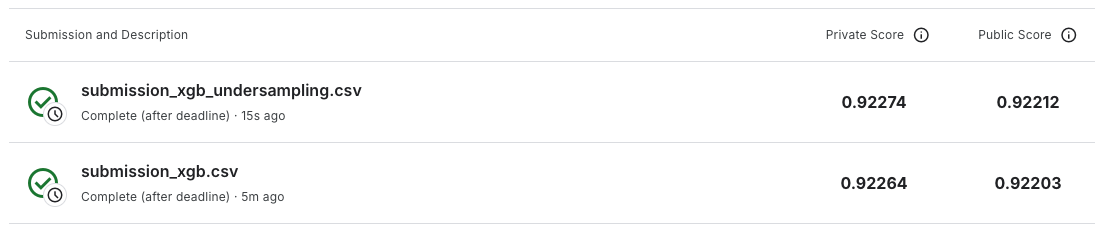

## Submissão dos Resultados
Utilizamos o modelo final do XGBoost para gerar as predições no conjunto de teste.
Nossas predições obteram uma AUC-ROC de 0.92264 e 0.92274 na competição.

O top 3 obteve 0.92849, 0.92827 e 0.92819.

Porém, entre nosso resultado e os melhores resultados, estavam contemplados muitas submissões. Nossa posição final foi aproximadamente 1500º lugar entre 3726 participantes.